**Calibration of spatial deterministic model** (focus on arrondissements)

Notes:
1. Based on calibration of national deterministic model found in ...
2. Includes Proximus mobility matrices that is updated every day
3. Includes three-fold stratified $\beta$ parameter (rural/urban/metropolitan)

# Load Python packages

In [103]:
# Load packages
# Established packages
import os
import numpy as np
import pandas as pd
import geopandas as gp
import datetime
import math
import xarray as xr # labels in the form of dimensions, coordinates and attributes
import matplotlib.pyplot as plt
import zarr

# Custom package covid19model
from covid19model.models import models
from covid19model.data import model_parameters, mobility # sciensano, google mobility
from covid19model.visualization.output import population_status, infected, show_map, show_graphs
from covid19model.models.time_dependant_parameter_fncs import lockdown_func, mobility_update_func
from covid19model.models.time_dependant_parameter_fncs import google_lockdown, ramp_fun, contact_matrix

# Functions for calibration (PSO first, MCMC later)
from covid19model.optimization import pso, objective_fcns

# Moving average for visualisation
from covid19model.visualization.utils import moving_avg

# Additional functions needed to simplify Notebook code
from covid19model.models.utils import read_pops, read_coordinates_nis, initial_state

# Download function for complete calibration
# covid19model.optimization.run_optimization import full_calibration_wave1, full_calibration_wave2


# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

# Spatial stratification
agg = 'arr'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load model parameter values
The model is supported by many parameters, which must be loaded into the model later on

In [60]:
# Load interaction matrices. Data taken from willem2012. No CoMix data used yet!
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012', spatial=agg)
# levels = initN.size
Nc_all = {'total': Nc_total, 'home':Nc_home, 'work': Nc_work, 'schools': Nc_schools, 'transport': Nc_transport, 'leisure': Nc_leisure, 'others': Nc_others}

In [61]:
# Mobility reduction in 6 categories from Google
df_google = mobility.get_google_mobility_data(update=False, plot=False)
df_google.tail(2)
# df_google.head()

,retail_recreation,grocery,parks,transport,work,residential
date,,,,,,
2021-03-04,-40.0,2.0,-20.0,-36.0,-26.0,13.0
2021-03-05,-37.0,11.0,19.0,-28.0,-23.0,12.0


In [78]:
# Define the sloped functions defining the changes in interaction patterns. Copied from JV-calibration-COVID19-SEIRD-WAVE1-comix.ipynb
def wave1_policies(t, states, param, df_google, Nc_all, l , tau, 
                   prev_schools, prev_work, prev_transport, prev_leisure, prev_others, prev_home):
    
    # Convert tau and l to dates
    tau_days = pd.Timedelta(tau, unit='D')
    l_days = pd.Timedelta(l, unit='D')

    # Define additional dates where intensity or school policy changes
    t1 = pd.Timestamp('2020-03-15') # start of lockdown
    t2 = pd.Timestamp('2020-05-18') # gradual re-opening of schools (15%)
    t3 = pd.Timestamp('2020-06-04') # further re-opening of schools (65%)
    t4 = pd.Timestamp('2020-07-01') # closing schools (end calibration wave1)

    if t <= t1 + tau_days:
        return contact_matrix(t, df_google, Nc_all, school=1)
    elif t1 + tau_days < t <= t1 + tau_days + l_days:
        policy_old = contact_matrix(t, df_google, Nc_all, school=1)
        policy_new = contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_transport, 
                                    prev_leisure, prev_others, school=0)
        return ramp_fun(policy_old, policy_new, t, tau_days, l, t1)
    elif t1 + tau_days + l_days < t <= t2:
        return contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_transport, 
                              prev_leisure, prev_others, school=0)
    elif t2 < t <= t3:
        return contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_transport, 
                              prev_leisure, prev_others, school=0.15)
    elif t3 < t <= t4:
        return contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_transport, 
                              prev_leisure, prev_others, school=0.65)
    else:
        return contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_transport, 
                              prev_leisure, prev_others, school=0)

In [79]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters(spatial=agg)
start_date = pd.to_datetime('2020-03-15') # first lockdown date

# Add the social effect of the first lockdown
params.update({'df_google': df_google,
              'Nc_all' : Nc_all,
               'l' : 5,
               'tau' : 5,
               'prev_schools': 0.5,
               'prev_work': 0.5,
               'prev_transport': 0.5,
               'prev_leisure': 0.5,
               'prev_others': 0.5,
               'prev_home' : 0.5
              })

# Add parameters for the daily update of proximus mobility
params.update({'agg' : agg,
               'default_mobility' : None}) # mobility defaults to average mobility of 2020 if no data is available

# Add clearly distinct infectivity parameters for demonstration for SANITY CHECK. Comment out for default beta values
# beta_R = 0.0
# beta_U = 0.0
# beta_M = 0.035
# params.update({'beta_R' : beta_R,
#                'beta_U' : beta_U,
#                'beta_M' : beta_M})

# Initialise model
The spatial model must have an initial condition. There are many choices, all included in the `initial_state` function. We choose the initial distribution to be only in Brussels, and the initial exposed individual is 40-50 years old. This is to some extent an arbitrary choice, but inspired by the idea that the first case is imported by plane (Brussels-Zaventem).

Other choices for initial conditions can be explored by inspection of the function description (`initial_state?`).

The simulation is run and plotted once for the default parameter values to demonstrate its effect.

In [93]:
# Initial states: single 30 year old exposed individual in Brussels
initE = initial_state(dist='bxl', agg=agg, age=40, number=1) # 1 40-somethings dropped in Brussels (arrival by plane)
initial_states = {'S': initN, 'E': initE}

# Initiate model with initial states, defined parameters, and lockdown_func determining the evolution of Nc
model_wave1 = models.COVID19_SEIRD_spatial(initial_states, params, time_dependent_parameters = \
                                           {'Nc' : wave1_policies, 'place' : mobility_update_func}, spatial=agg)

# Temporal range of the simulation
# Recall tha lockdown date was defined earlier
end_date = pd.to_datetime('2020-06-15') # end simulation before gradual reopening of schools (May 18th)
start_date = pd.to_datetime('2020-01-15')
out = model_wave1.sim(end_date, start_date=start_date)

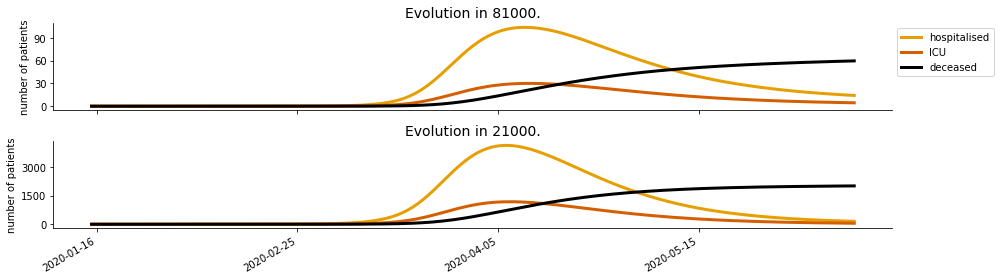

In [94]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(14,4))

place1=81000 # Arlon
place2=21000 # Brussels

infected(out.sel(place=place1), ax=ax1)
ax1.grid(False)
ax1.set_xlabel(None)
ax1.set_title(f"Evolution in {place1}.", fontsize=14)

infected(out.sel(place=place2), ax=ax2)
ax2.grid(False)
ax2.set_xlabel(None)
ax2.set_title(f"Evolution in {place2}.", fontsize=14)
ax2.get_legend().remove()

for ax in fig.get_axes():
    ax.label_outer()

plt.tight_layout()
# plt.savefig("test", dpi=200)

# Load and show all hospitalisation data per arrondissement
The model is calibrated on daily new hospitalisations (`H_in`). This data is found in the nonpublic repository. 7-day averaged data is available from March 5th 2020. This is almost two weeks prior to the first lockdown (March 18th). Mobility data is available for this date.

In [66]:
nonpublic_file = '../../../COVID19_spatial_private/interim/all_nonpublic_timeseries_' + agg + '.csv'
nonpublic_ts = pd.read_csv(nonpublic_file, parse_dates=['DATE']).pivot_table(index='DATE', columns='NIS_' + agg, values='hospitalised_IN')

nonpublic_ts_avg = nonpublic_ts.copy()
for NIS in nonpublic_ts_avg.columns:
    nonpublic_ts_avg[[NIS]] = moving_avg(nonpublic_ts[[NIS]])

# Note the NaN values due to the moving average
nonpublic_ts_avg.dropna(inplace=True)
nonpublic_ts_avg.head(2)

NIS_arr,11000,12000,13000,21000,23000,24000,25000,31000,32000,33000,...,72000,73000,81000,82000,83000,84000,85000,91000,92000,93000
DATE,,,,,,,,,,,,,,,,,,,,,
2020-03-05,1.857143,1.000000,0.428571,3.857143,1.000000,0.571429,0.571429,0.571429,0.0,0.0,...,0.0,0.285714,0.0,0.142857,0.285714,0.428571,0.000000,0.714286,0.571429,0.285714
2020-03-06,1.857143,1.142857,0.428571,5.000000,1.142857,0.714286,0.571429,0.714286,0.0,0.0,...,0.0,0.571429,0.0,0.142857,0.285714,0.571429,0.142857,0.714286,0.571429,0.285714


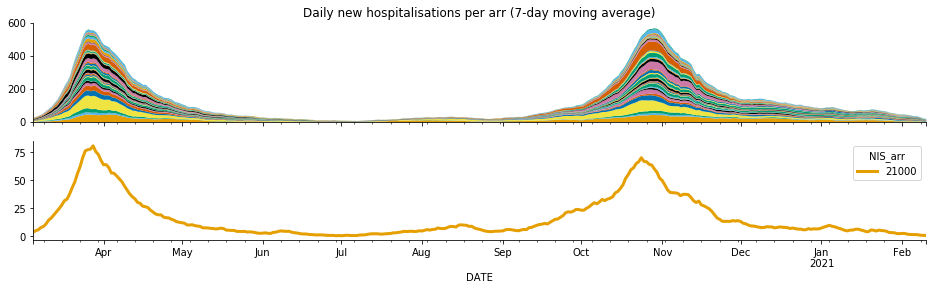

In [92]:
# Show all 43 time series
fig, (ax2, ax3) = plt.subplots(2, 1, figsize=(16, 4))

nonpublic_ts_avg.plot(ax=ax2, linewidth=0, kind='area')
ax2.legend().remove()
ax2.grid(False)
xlabel=ax2.set_xlabel(None)
title=ax2.set_title(f'Daily new hospitalisations per {agg} (7-day moving average)')
ylim=ax2.set_ylim([0, 600])

# Add data for one NIS
NIS_choice=21000
nonpublic_ts_avg[[NIS_choice]].plot(ax=ax3)
# ax3.legend().remove()
ax3.grid(False)
# title=ax3.set_title(f'Daily new hospitalisations for NIS {NIS_choice} (7-day moving average)')

for ax in fig.get_axes():
    ax.label_outer()

# Calibration

The code below is mostly copied from `JV-calibration-COVID19-SEIRD-WAVE1.ipynb` and the functions used there.

In [95]:
# Date of first data collection
start_calibration = '2020-03-05' # first available date
# Last datapoint used to calibrate prevention parameters
end_calibration = '2020-07-01' 

# Path where figures should be stored
fig_path = '../../results/calibrations/COVID19_SEIRD/national/'
# Path where MCMC samples should be saved
samples_path = '../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/'
# Spatial unit: identifier
spatial_unit = f'{agg}_willem2012_prev_thin'

In [100]:
# define dataset from the start and end date
data=[nonpublic_ts_avg[start_calibration:end_calibration]]

# Define the compartment that the calibration will be looking at
states = [["H_in"]]

In [ ]:
# Initial conditions for calibration
init_warmup = 30
maxiter = 100
popsize = 100
processes = 16 # voor eraser!! ## PROCESSES=1 to debug!
steps_mcmc = 3000 #3000
discard = 1000 #1000

In [101]:
####################################################
####### CALIBRATING BETA AND COMPLIANCE RAMP #######
####################################################

print('------------------------------------')
print('CALIBRATING BETA AND COMPLIANCE RAMP')
print('------------------------------------\n')
print('Using data from '+start_calibration+' until '+end_calibration+'\n')
print('1) Particle swarm optimization\n')

# set PSO optimisation settings
parNames = ['sigma_data','beta_R', 'beta_U', 'beta_M', 'l', 'tau',
            'prev_schools', 'prev_work', 'prev_transport', 'prev_leisure', 'prev_others', 'prev_home', 'warmup']
bounds=((1,2000),(0.010,0.060),(0.010,0.060),(0.010,0.060), (0.1,20),(0.1,20),
        (0,1),(0,1),(0,1),(0,1),(0,1),(0,1), (30,60))

# run PSO optimisation
theta_pso = pso.fit_pso(model,data,parNames,states,bounds,maxiter=maxiter,popsize=popsize,
                    start_date=start_calibration,warmup=init_warmup, processes=processes) 
warmup = int(theta_pso[-1])

------------------------------------
CALIBRATING BETA AND COMPLIANCE RAMP
------------------------------------

Using data from 2020-03-05 until 2020-07-01

1) Particle swarm optimization



In [104]:
pso.fit_pso?

# Scratches